## Libraries

In [1]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy.ndimage import gaussian_filter1d
from matplotlib.path import Path


## Defining what trial and set we are studying

In [14]:
set=1
trial=5

## Open Image

In [3]:
path="C:/Users/anama/OneDrive/Ambiente de Trabalho/UNI/Semestre2/ICSTS/Task3/ICSTS_EIT_Processment/set_0"+str(set)+"/trial_0"+str(trial)+"/frame_004.png"
# Read image 
image = cv2.imread(path)

## RoI Selection

In [30]:
# Select left lung ROI manually
r_left=cv2.selectROI("select the area left", image) # After selecting inted region press enter
cv2.destroyWindow("select the area left")

In [4]:
r_left=220, 169, 194, 339

In [ ]:
# Select left lung ROI manually
r_right=cv2.selectROI("select the area right", image) # After selecting inted region press enter
cv2.destroyWindow("select the area right")


In [5]:
r_right=498, 169, 194, 339

In [33]:
# Draw rectangle on the original image
r=r_left
image_with_roi = image.copy()
cv2.rectangle(image_with_roi, (r[0], r[1]), (r[0] + r[2], r[1] + r[3]), (0, 0, 255), 2)  # Red rectangle

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [34]:
# Show the ROI (optional)
cv2.imshow("Image with ROI", image_with_roi)
cv2.waitKey(0)
cv2.destroyWindow("Image with ROI")

## Apply RoI to all images

In [15]:
# Open all images from trial 1
image_files = sorted(glob("C:/Users/anama/OneDrive/Ambiente de Trabalho/UNI/Semestre2/ICSTS/Task3/ICSTS_EIT_Processment/set_0"+str(set)+"/trial_0"+str(trial)+'/*.png'))  # Sort to preserve time order

In [16]:
# Set example image
r=r_left

image = Image.open(image_files[0])
image_np = np.array(image)
sample_image= image_np[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])] 

# Example shape from first image
sample_array = np.array(sample_image)
height, width, channels = sample_array.shape  # assuming RGB

# Preallocate image array (e.g., N images × H × W × C)
image_array = np.zeros((len(image_files), height, width, channels), dtype=np.uint8)


In [17]:
for image_num in range(len(image_files)):
    image = Image.open(image_files[image_num])
    image_np = np.array(image)
    image= image_np[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])] 

    image_array[image_num]=image

In [38]:
cv2.imshow("Image", image_array[40])
cv2.waitKey(0)
cv2.destroyWindow("Image")

## Get EIT Impedance waveform

In [18]:
impedance_means = []

for image in image_array:
    
    # Convert to grayscale if needed, or to HSV to isolate intensity
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    intensity = hsv[:, :, 2]  # Value channel often correlates with impedance

    # Compute variance of pixel values (impedance variance estimate)
    mean_intensity = np.mean(intensity)
    impedance_means.append(mean_intensity)

In [19]:
# Convert to NumPy array for easy slicing
impedance_means = np.array(impedance_means)

# Number of images per second
fps = 33

# Number of full seconds in the data
num_seconds = len(impedance_means) // fps

# Reshape and compute mean over each second
impedance_1hz = impedance_means[:num_seconds * fps].reshape(num_seconds, fps).mean(axis=1)

In [20]:
impedance_means = np.array(impedance_1hz)
baseline = np.min(impedance_1hz)
normalized_signal = (impedance_1hz - np.mean(impedance_1hz)) / np.std(impedance_1hz)

In [21]:
smoothed_signal = gaussian_filter1d(normalized_signal, sigma=2)

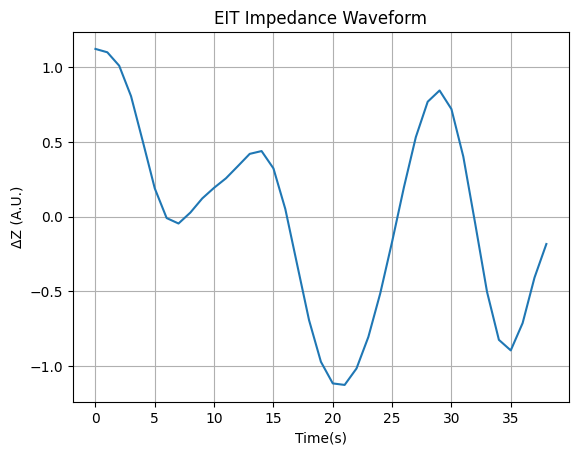

In [22]:
plt.plot(smoothed_signal)
plt.title("EIT Impedance Waveform")
plt.xlabel("Time(s)")
plt.ylabel("ΔZ (A.U.)")
plt.grid(True)
plt.show()

## Lung Similarity Study

Peak and Troughs Detection

In [45]:
# Peaks represent Experation
expiration_time=scipy.signal.find_peaks(smoothed_signal)[0]
expiration_time


array([ 5, 15])

In [46]:
# Throughs represent Inspiration
inspiration_time=scipy.signal.find_peaks(-smoothed_signal)[0]
inspiration_time

array([12, 19])

Select Correct Frames

In [47]:
# Calculate which frames correspond to experation
expiration_frames=expiration_time*33
expiration_frames

array([165, 495])

In [48]:
# Calculate which frames correspond to experation
inspiration_frames=inspiration_time*33
inspiration_frames

array([396, 627])

Calculate impedance values in the given frames

In [52]:
diff_expiration=np.zeros(len(expiration_frames))

i=0

for frame in expiration_frames:

    image = Image.open(image_files[frame])
    image_np = np.array(image)

    studied_frame_right=image_np[int(r_right[1]):int(r_right[1]+r_right[3]),int(r_right[0]):int(r_right[0]+r[2])] 
    studied_frame_left=image_np[int(r_left[1]):int(r_left[1]+r_left[3]),int(r_left[0]):int(r_left[0]+r_left[2])] 

    hsv_right = cv2.cvtColor(studied_frame_right, cv2.COLOR_BGR2HSV)
    intensity_right = hsv_right[:, :, 2] 
    hsv_left = cv2.cvtColor(studied_frame_left, cv2.COLOR_BGR2HSV)
    intensity_left = hsv_left[:, :, 2] 

    mean_intensity_right = np.mean(valid_pixels_right)
    mean_intensity_left = np.mean(valid_pixels_left)

    diff_expiration[i]=abs(mean_intensity_right-mean_intensity_left)

    i+=1

media=sum(diff_expiration)/len(diff_expiration) 
media

np.float64(0.5692663078978342)

In [51]:
diff_inspiration=np.zeros(len(inspiration_frames))

i=0

for frame in inspiration_frames:

    image = Image.open(image_files[frame])
    image_np = np.array(image)

    studied_frame_right=image_np[int(r_right[1]):int(r_right[1]+r_right[3]),int(r_right[0]):int(r_right[0]+r[2])] 
    studied_frame_left=image_np[int(r_left[1]):int(r_left[1]+r_left[3]),int(r_left[0]):int(r_left[0]+r_left[2])] 

    hsv_right = cv2.cvtColor(studied_frame_right, cv2.COLOR_BGR2HSV)
    intensity_right = hsv_right[:, :, 2] 
    hsv_left = cv2.cvtColor(studied_frame_left, cv2.COLOR_BGR2HSV)
    intensity_left = hsv_left[:, :, 2] 

    mean_intensity_right = np.mean(valid_pixels_right)
    mean_intensity_left = np.mean(valid_pixels_left)

    diff_inspiration[i]=abs(mean_intensity_right-mean_intensity_left)

    i+=1

media=sum(diff_inspiration)/len(diff_inspiration) 
media

np.float64(0.5692663078978342)

If the median difference is close to 0, both lungs are likely ventilating symmetrically during expiration.

A positive median suggests that one lung (e.g., left) shows consistently higher ΔZ, implying greater volume loss or air content — potentially better ventilation.

A negative median implies the opposite — possibly reduced ventilation on that side.